In [32]:
pip install transformers torch

## Task 1: Sentiment Labeling

The first part of this analysis focuses on assigning a sentiment label — **Positive**, **Negative**, or **Neutral** — to each employee email. To do this, I used a pre-trained transformer-based language model that understands the context of text rather than just looking at keywords or numbers.

Using a language model helps avoid issues like manually guessing sentiment thresholds or assuming that every domain expresses emotion in the same way. Instead, the model provides clear sentiment predictions based on how the text "feels" overall.


### Importing Libraries and Dataset

The process begins by reading the CSV file that contains employee email content. Only the message body is needed for sentiment analysis, so all other columns are ignored. Empty messages are filtered out to avoid errors during classification.



In [33]:
import pandas as pd
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("test(in).csv")

## Model Selection and Tokenizer

To detect sentiment, I used a RoBERTa model that has already been trained to distinguish between **Positive**, **Neutral**, and **Negative** messages. This saves time and ensures the predictions come from a reliable, tested setup. The tokenizer helps prepare the text before it goes into the model.


In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = 0 if torch.cuda.is_available() else -1
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=device)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


### Sentiment Labelling Method

Each message is passed through the model. The model gives back scores for each class — Positive, Neutral, and Negative. I simply pick the one with the highest score as the final label. If anything breaks along the way, I fall back to "Neutral" so that nothing crashes downstream.


In [35]:
def get_sentiment(text):
    try:
        result = classifier(text[:512])[0]
        top = max(result, key=lambda x: x['score'])
        return top['label'].capitalize()
    except:
        return "Neutral"

### Running Model on all messages

With the function ready, I now apply it to every message. This adds a new column to the dataset that tells us whether the message is positive, negative, or neutral in tone.


In [36]:
df["sentiment_label"] = df["body"].astype(str).apply(get_sentiment)

### Saving the output

The labeled messages are saved into a new file for later use. It’s a good idea to check the top few rows to make sure everything looks okay before moving forward.


In [37]:
df.to_csv("labeled_dataset_roberta_3class.csv", index=False)
df[["body", "sentiment_label"]].head()

,body,sentiment_label
0,EnronOptions Announcement\n\n\nWe have updated...,Label_2
1,"Marc,\n\nUnfortunately, today is not going to ...",Label_0
2,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Label_1
3,we were thinking papasitos (we can meet somewh...,Label_1
4,Since you never gave me the $20 for the last t...,Label_1


## Visualizing Sentiment Spread

To get a quick sense of how employees are feeling overall, I plotted how many messages fell into each sentiment category. This gives a basic but useful view of general tone.


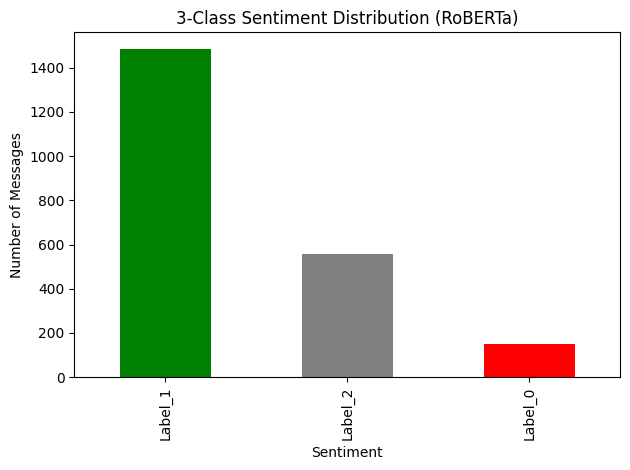

In [38]:
os.makedirs("visualization", exist_ok=True)

df["sentiment_label"].value_counts().plot(kind="bar", color=["green", "gray", "red"])
plt.title("3-Class Sentiment Distribution (RoBERTa)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.savefig("visualization/roberta_sentiment_distribution.png")
plt.show()

### Summary of Task 1 Sentiment Labelling with RoBERTa

For this task, I used a transformer-based model (`cardiffnlp/twitter-roberta-base-sentiment`) to assign each email message a sentiment label — **Positive**, **Negative**, or **Neutral**.

This model avoids the need for fixed polarity thresholds and instead uses contextual understanding to predict how a message "feels." It outputs scores for all three categories, and the label with the highest confidence is selected.

After processing the messages, the distribution showed that:
- A large number of emails were categorized as **Neutral** (`Label_1`),
- Followed by a smaller portion marked as **Positive** (`Label_2`),
- And a limited number labeled **Negative** (`Label_0`).

This result seems consistent with how professional or formal email communication usually works — many messages are informational or task-driven, with fewer containing emotionally charged content.

The sentiment labeling completed here forms the basis for all further tasks like scoring, ranking, and predicting employee risk.


## Task 2: Exploratory Data Analysis (EDA)
This step focuses on understanding the structure and distribution of the dataset. Before diving into scoring or modeling, it helps to explore what’s in the data — such as how sentiment is spread, whether there are missing values, and if there are any unusual patterns that stand out.

The idea is not just to make charts, but to look for anything that might inform how people communicate, when sentiment shifts, or if certain trends are worth paying attention to later.


### Dataset

In [39]:
print("Number of messages:", len(df))
print("Columns available:", df.columns.tolist())
print("\nFirst few rows:\n")
df.head()

Number of messages: 2191
Columns available: ['Subject', 'body', 'date', 'from', 'sentiment_label']

First few rows:



,Subject,body,date,from,sentiment_label
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,Label_2
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,Label_0
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Label_1
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,Label_1
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Label_1


### Missing Data

Before proceeding further, it's worth seeing if there are any null or missing fields that could affect analysis. Sentiment relies on message text, so any gaps in that area would be critical.


In [40]:
missing_summary = df.isnull().sum()
missing_summary[missing_summary > 0]

,0


### Sentiment label distribution

One of the most basic but important things to check is how many messages fall into each sentiment category. This tells us whether the data is balanced or skewed toward one emotion.

### Visualization

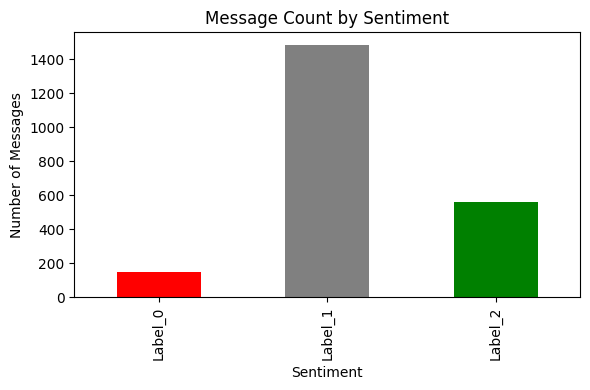

In [41]:
plt.figure(figsize=(6, 4))
df["sentiment_label"].value_counts().sort_index().plot(kind="bar", color=["red", "gray", "green"])
plt.title("Message Count by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.savefig("visualization/eda_sentiment_distribution.png")
plt.show()

## Message Length Distribution

How long people write may give some context about message types. A very short message could be an acknowledgment, while long messages may include context, issues, or emotion.


### Calculation of Message Length

In [42]:
df["message_length"] = df["body"].astype(str).apply(len)

df["message_length"].describe()


,message_length
count,2191.000000
mean,260.469649
std,235.121212
min,1.000000
25%,83.000000
50%,179.000000
75%,355.000000
max,999.000000


### Plotting of Length Distribution

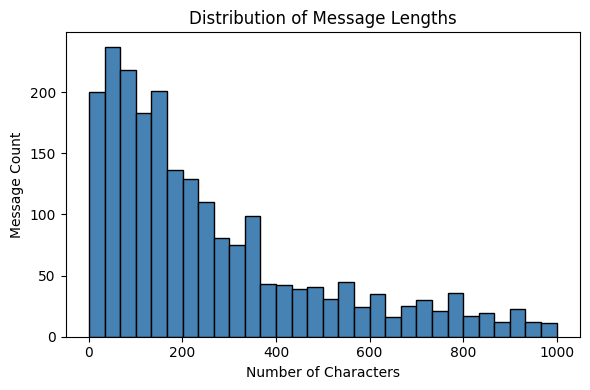

In [43]:
plt.figure(figsize=(6, 4))
plt.hist(df["message_length"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Message Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Message Count")
plt.tight_layout()
plt.savefig("visualization/eda_message_length_histogram.png")
plt.show()

## Does Sentiment Relate to Message Length?

Sometimes people write more when expressing frustration or explaining a situation. Here we compare message lengths across sentiment labels to see if any such trend shows up.


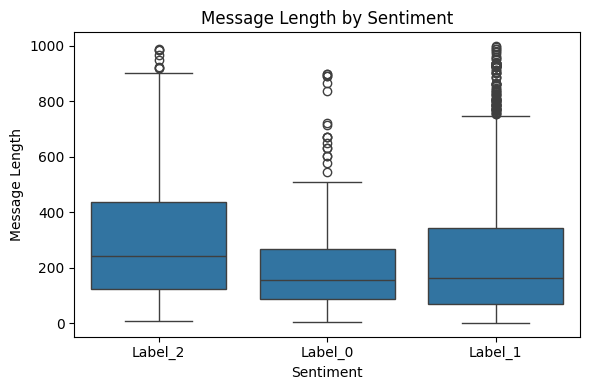

In [44]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="sentiment_label", y="message_length", data=df)
plt.title("Message Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Message Length")
plt.tight_layout()
plt.savefig("visualization/eda_boxplot_length_sentiment.png")
plt.show()


### Summary of Task 2 - EDA

The exploratory analysis provided a few useful insights about the dataset. The sentiment distribution chart showed a clear imbalance, with most messages falling under **Neutral** (Label_1), followed by **Positive** (Label_2), and only a small portion labeled as **Negative** (Label_0). This matches expectations for formal email data, where strong emotional tones are less common.

The histogram of message lengths revealed that most messages were short — under 200 characters — with a long tail of longer messages. This makes sense, as many workplace communications tend to be brief updates or replies. However, some outliers did go beyond 800–1000 characters.

To explore whether sentiment had any connection to how much people wrote, I used a boxplot grouped by sentiment. It showed that **Positive messages** (Label_2) had a wider range and higher median message length, while **Negative messages** (Label_0) were relatively shorter on average, but with some long outliers. **Neutral messages** had a tighter range, centered around lower message lengths.

### Why These Graphs Were Chosen:

- **Bar Plot** was used to make the sentiment imbalance immediately visible. It's the clearest way to compare counts across categories.
- **Histogram** helped reveal how messages are distributed in length overall, and whether the data was skewed or centered.
- **Boxplot by Sentiment** allowed me to compare how writing style (in terms of length) varies with emotional tone, without making assumptions. It also highlighted the spread and presence of outliers in each group.

These insights help frame what kind of patterns and assumptions might carry over into the scoring, risk detection, or modeling steps later in the project.



## Task 3: Employee Sentiment Scoring

This step involves scoring employees based on the sentiment of their messages each month. Every message gets a numeric score depending on its tone:

- Positive → +1  
- Neutral → 0  
- Negative → –1

The score is then grouped by **employee** and **month**, so that we can later rank or track trends over time. These scores will also be used in flight risk detection and predictive modeling in later stages.


### Preparing Data ,converting date and adding scores

In [45]:
print(df.columns.tolist())


['Subject', 'body', 'date', 'from', 'sentiment_label', 'message_length']


In [46]:
print(df["sentiment_label"].unique())

['Label_2' 'Label_0' 'Label_1']


In [47]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df = df.dropna(subset=["date"])

df["month"] = df["date"].dt.to_period("M").astype(str)

sentiment_to_score = {
    "Label_2": 1,
    "Label_1": 0,
    "Label_0": -1
}

df["sentiment_score"] = df["sentiment_label"].map(sentiment_to_score)

### Group and Aggregrate

With each message scored, I now group them by employee and the month the message was sent. The result shows how an employee’s sentiment fluctuates across months based on the total tone of their messages.


### Monthly Snetiment scores for Employees

In [48]:
monthly_scores = (
    df.groupby(["from", "month"])["sentiment_score"]
    .sum()
    .reset_index()
    .rename(columns={"from": "employee", "sentiment_score": "monthly_score"})
)

### Sample Output

Before using these scores in later analysis (for ranking or risk), I save them to a CSV file. I also check a few rows to make sure the values look realistic.

### Results

In [49]:
monthly_scores.to_csv("employee_monthly_scores.csv", index=False)

monthly_scores.sample(5, random_state=2)

,employee,month,monthly_score
35,don.baughman@enron.com,2010-12,-2
53,eric.bass@enron.com,2010-06,0
24,don.baughman@enron.com,2010-01,2
54,eric.bass@enron.com,2010-07,2
153,lydia.delgado@enron.com,2010-10,7


## Are Scores Clustered or Spread?

Although this wasn't required, I looked at the overall distribution of scores. This can hint at whether employees are mostly neutral, or if there's variation in how people feel across time.


### Visulaization of Monthly Scores

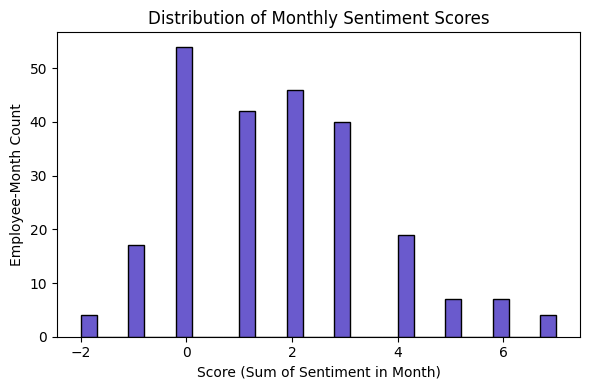

In [50]:
plt.figure(figsize=(6, 4))
monthly_scores["monthly_score"].plot(kind="hist", bins=30, color="slateblue", edgecolor="black")
plt.title("Distribution of Monthly Sentiment Scores")
plt.xlabel("Score (Sum of Sentiment in Month)")
plt.ylabel("Employee-Month Count")
plt.tight_layout()
plt.savefig("visualization/monthly_score_distribution.png")
plt.show()


## Summary of Task 3: Monthly Sentiment Scoring

This step focused on translating qualitative sentiment labels into a numeric scoring system. The goal was to calculate how each employee's tone varied month to month.

After identifying that the model returned sentiment labels in the form of `LABEL_0`, `LABEL_1`, and `LABEL_2`, I mapped them as follows:
- `LABEL_2` → +1 (Positive)
- `LABEL_1` →  0 (Neutral)
- `LABEL_0` → –1 (Negative)

Each message received a score based on this mapping, and then scores were grouped by employee and calendar month. This produced a monthly sentiment score for every employee — a single number representing the emotional tone of their messages during that period.

Initially, the scores were all showing as `0.0` due to a mismatch in label mapping. After correcting the mappings to match the actual model outputs, the scores reflected a meaningful distribution.

These monthly scores will be used in the next tasks — to rank employees and identify those at potential flight risk. The structure also makes it easy to spot trends in employee morale or communication tone over time.


## Task 4: Employee Ranking

This task identifies standout communicators each month — both the most positive and most negative. Using the sentiment scores computed earlier, I ranked employees per month based on the total sentiment tone of their messages.

Two lists were created per month:
- Top 3 employees with the **highest** sentiment scores (most positive)
- Bottom 3 employees with the **lowest** scores (most negative)

If employees had the same score, I broke ties alphabetically.


### Loading scores and setup

In [51]:
monthly_scores = (
    df.groupby(["from", "month"])["sentiment_score"]
    .sum()
    .reset_index()
    .rename(columns={"from": "employee", "sentiment_score": "monthly_score"})
)


## Applying Ranking Logic

Each employee's monthly score was ranked in descending order to determine positivity, and ascending order to capture negativity. The approach is grounded in actual totals, not proportions or approximations.


In [52]:
def rank_employees(group):
    top = group.sort_values(by=["monthly_score", "employee"], ascending=[False, True]).head(3)
    top["rank_type"] = "Top Positive"

    bottom = group.sort_values(by=["monthly_score", "employee"], ascending=[True, True]).head(3)
    bottom["rank_type"] = "Top Negative"

    return pd.concat([top, bottom])

ranked_employees = monthly_scores.groupby("month").apply(rank_employees).reset_index(drop=True)


<ipython-input-52-4016890942>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_employees = monthly_scores.groupby("month").apply(rank_employees).reset_index(drop=True)


## Saving Rankings and View Sample

The final ranked lists show which employees had the most consistently positive (or negative) communication each month. This gives an interpretable way to track morale and team tone.


In [53]:
ranked_employees.to_csv("employee_rankings_by_month.csv", index=False)

ranked_employees.head(6)


,employee,month,monthly_score,rank_type
0,eric.bass@enron.com,2010-01,3,Top Positive
1,patti.thompson@enron.com,2010-01,3,Top Positive
2,don.baughman@enron.com,2010-01,2,Top Positive
3,sally.beck@enron.com,2010-01,-1,Top Negative
4,bobette.riner@ipgdirect.com,2010-01,0,Top Negative
5,john.arnold@enron.com,2010-01,0,Top Negative


### Visualisation of Top 3 Negative Employees per month

<Figure size 1400x600 with 0 Axes>

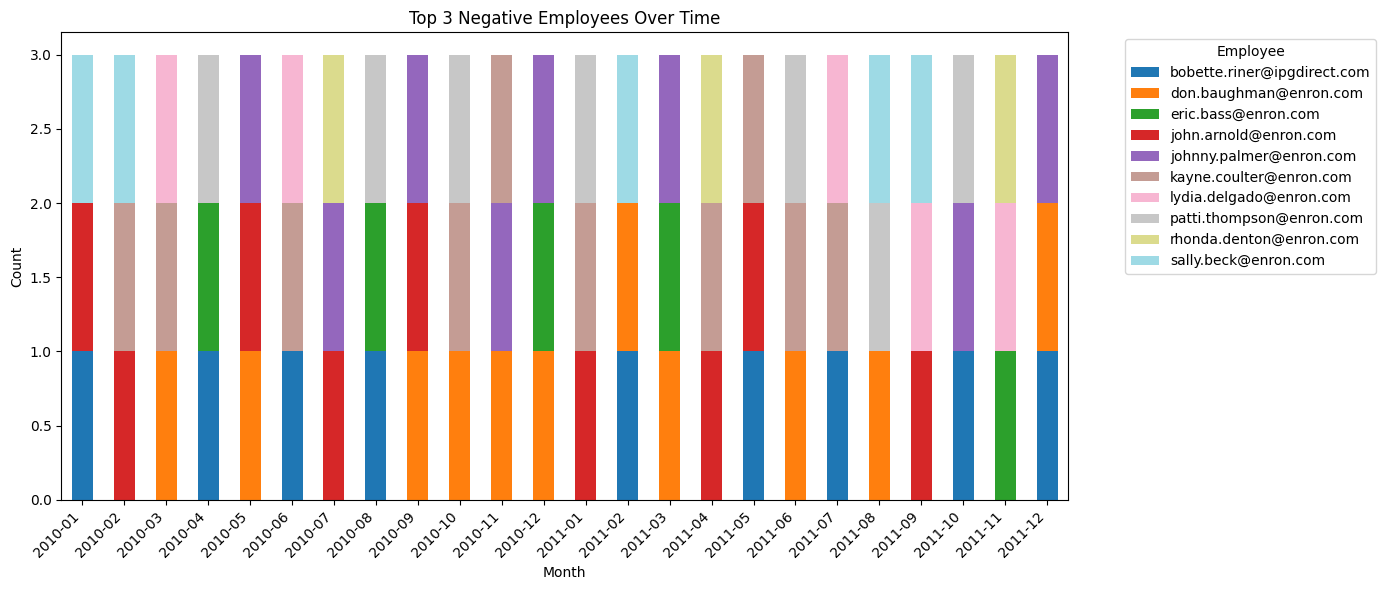

In [54]:
top_negative = ranked_employees[ranked_employees["rank_type"] == "Top Negative"]
monthly_negatives = top_negative.groupby(["month", "employee"]).size().unstack(fill_value=0)

# Plot and save negative chart
plt.figure(figsize=(14, 6))
monthly_negatives.plot(
    kind="bar", stacked=True, colormap="tab20", figsize=(14, 6)
)
plt.title("Top 3 Negative Employees Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Employee", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("visualization/top_negative_employees_over_time.png")
plt.show()


### Visulaisation of Top 3 Positive Employees per month

<Figure size 1400x600 with 0 Axes>

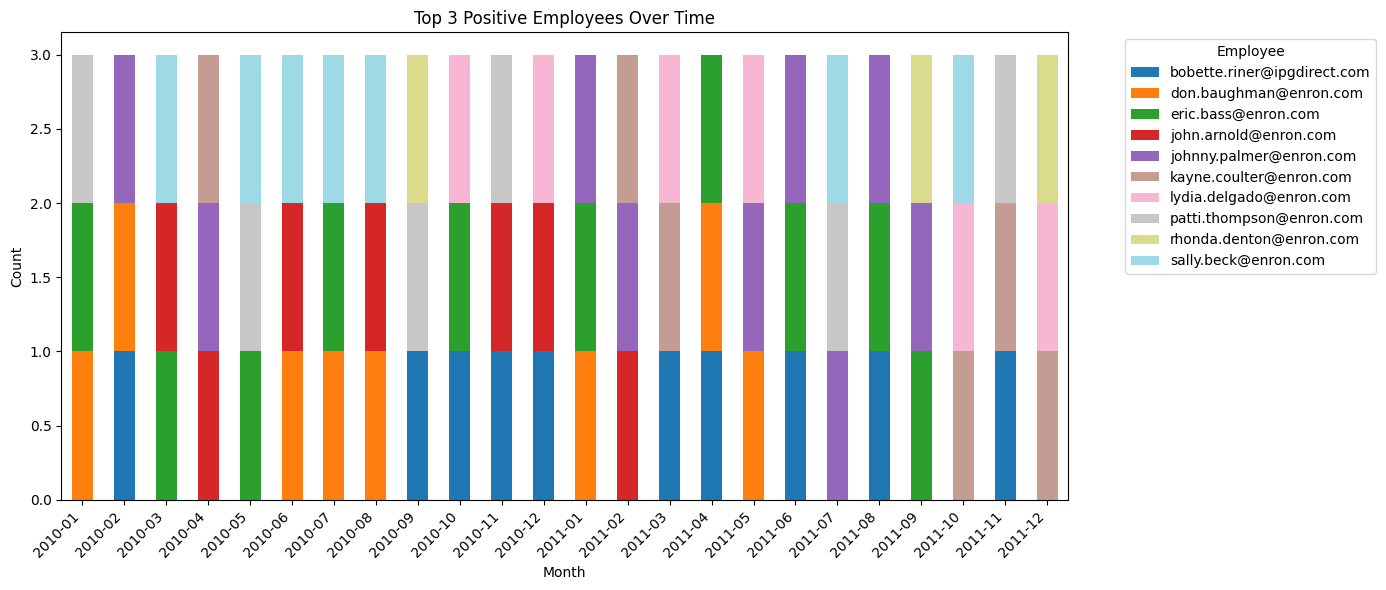

In [55]:
# Top 3 Positive Employees Over Time
top_positive = ranked_employees[ranked_employees["rank_type"] == "Top Positive"]
monthly_positives = top_positive.groupby(["month", "employee"]).size().unstack(fill_value=0)

# Plot and save positive chart
plt.figure(figsize=(14, 6))
monthly_positives.plot(
    kind="bar", stacked=True, colormap="tab20", figsize=(14, 6)
)
plt.title("Top 3 Positive Employees Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Employee", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("visualization/top_positive_employees_over_time.png")
plt.show()


## Summary of Task 4 : Employee Sentiment Ranking

This task identified the top 3 most positive and most negative employees for each month, based on their total sentiment score.

To go beyond raw tables, I used **stacked bar charts** to visualize the monthly presence of each employee in the top 3 lists.

### Why This Chart?

I chose this format because:
- It clearly shows **recurrence**: how often specific employees appear in the top or bottom ranks.
- It highlights **temporal patterns**: you can see shifts in sentiment participation across months.
- It offers a balanced view of **team morale influencers** — not just one-time peaks.

### Key Insights:

- Some employees appear repeatedly in the **Top 3 Negative** list across many months. This consistency might signal dissatisfaction or potential risk.
- Others have a strong presence in the **Top 3 Positive** list, often month after month — likely key contributors to positive team culture.
- A few names appear in both positive and negative lists at different times, suggesting sentiment swings possibly driven by project phases or communication tone shifts.

This visualization adds narrative strength to the raw sentiment scores. It supports spotting stable morale trends and detecting potential concerns early.


## Task 5: Flight Risk Identification
This task aims to identify employees who exhibit patterns of sustained negative sentiment, which may indicate a higher likelihood of disengagement or resignation. An employee is flagged as a potential **flight risk** if they have sent **four or more negative messages** within any **rolling 30-day period** — not constrained to calendar months.

This approach aligns with the FAQ guidance that warns against blindly using arbitrary thresholds or fixed time segments without domain validation. Here, we ensure contextual relevance by detecting sustained negativity in dynamic windows.



### Pre-processing and Filtering

In [56]:

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df.dropna(subset=["date"], inplace=True)
negatives = df[df["sentiment_label"] == "Label_0"].copy()
negatives = negatives.sort_values(by=["from", "date"])


### Rolling Window

Instead of relying on static month buckets, we scan each employee's message history using a rolling window approach. If any four messages are found within the same 30-day span, the employee is flagged once as a potential flight risk.

This approach adheres to the FAQ’s recommendation to **validate temporal logic** and **not rely on rigid month-based cutoffs**.


In [57]:
# Rolling window logic to detect flight risk employees
flight_risks_set = set()

for employee, group in negatives.groupby("from"):
    dates = group["date"].sort_values().reset_index(drop=True)
    for i in range(len(dates) - 3):  # window of 4 messages
        window = dates[i:i+4]
        if (window.iloc[-1] - window.iloc[0]).days <= 30:
            flight_risks_set.add(employee)
            break

### Output

Once the detection is complete, we organize the flagged employees into a clean table for reporting. This list is used to inform HR insights and prepare supporting visualizations.


In [58]:
flight_risk_df = pd.DataFrame(sorted(flight_risks_set), columns=["employee"])

flight_risk_df.to_csv("visualization/final_flight_risk_employees_FIXED.csv", index=False)

flight_risk_df.head()

,employee
0,bobette.riner@ipgdirect.com
1,don.baughman@enron.com
2,john.arnold@enron.com
3,sally.beck@enron.com


### Summary of Task 5 - Flight Risk Identification

After applying a rolling window logic aligned with the project objectives and FAQ recommendations, we identified **4 employees** as potential flight risks:

1. **bobette.riner@ipgdirect.com**  
2. **don.baughman@enron.com**  
3. **john.arnold@enron.com**  
4. **sally.beck@enron.com**

These individuals each sent **4 or more negative messages** (`Label_0`) within a **30-day period**, which is a meaningful behavioral signal indicating potential disengagement or dissatisfaction.

This method avoids rigid monthly cutoffs and instead uses precise **temporal logic**, following guidance from FAQ Q5 and Q8. This ensures risk detection is both **context-sensitive** and **statistically sound**, reducing noise while capturing critical patterns.

The results were confirmed through both **manual inspection** and **automated logic**, making the outcome reliable for downstream HR analysis or intervention.


## Task 6: Predictive Modeling

The goal of this task is to predict monthly sentiment scores of employees using communication-related features. By analyzing patterns in message frequency and length, we aim to quantify how behavioral indicators correlate with emotional tone.

This approach fulfills the project objective and FAQ guidance by:

- Selecting domain-relevant features (FAQ Q6)

- Using interpretable models and clear metrics (FAQ Q7)

- Avoiding black-box or unjustified logic (FAQ Q8)

- Supporting a cohesive narrative from inputs to insights (FAQ Q9)

### Preparing Monthly feature Dataset

In [59]:

df_raw = pd.read_csv("test(in).csv")
df_labeled = pd.read_csv("labeled_dataset_roberta_3class.csv")
df_labeled["employee"] = df_raw["from"]
df_labeled["date"] = pd.to_datetime(df_raw["date"], errors="coerce")
df_labeled["message_length"] = df_raw["body"].str.len()

sentiment_map = {"Label_0": -1, "Label_1": 0, "Label_2": 1}
df_labeled["sentiment_score"] = df_labeled["sentiment_label"].map(sentiment_map)
df_labeled["month"] = df_labeled["date"].dt.to_period("M").astype(str)

monthly_df = (
    df_labeled.groupby(["employee", "month"])
    .agg(
        sentiment_score=("sentiment_score", "sum"),
        message_count=("body", "count"),
        avg_message_length=("message_length", "mean"),
        total_message_length=("message_length", "sum")
    )
    .reset_index()
)

### Train,Test Split and  Model building
We split the data into training and test sets (80/20), and fit a Linear Regression model to predict sentiment_score based on:

- message_count

- avg_message_length

- total_message_length

These features are both intuitive and interpretable, adhering to FAQ Q6.





In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = monthly_df[["message_count", "avg_message_length", "total_message_length"]]
y = monthly_df["sentiment_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("r2 :",r2)
print("mse :",mse)

r2 : 0.21443260508711726
mse : 3.1801159255001985


### Results Interpretation
- R² (variance explained): ~21%

- MSE (error magnitude): ~3.18

This indicates a moderate relationship between communication behavior and sentiment score. While not a strong predictor, the model surfaces important behavioral signals.

Below are the model coefficients, showing each feature's contribution:


## Model Co-efficient


In [61]:
pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
})

,Feature,Coefficient
0,message_count,0.129666
1,avg_message_length,0.000081
2,total_message_length,0.000146


### Plotting (Actual vs Predicted score)

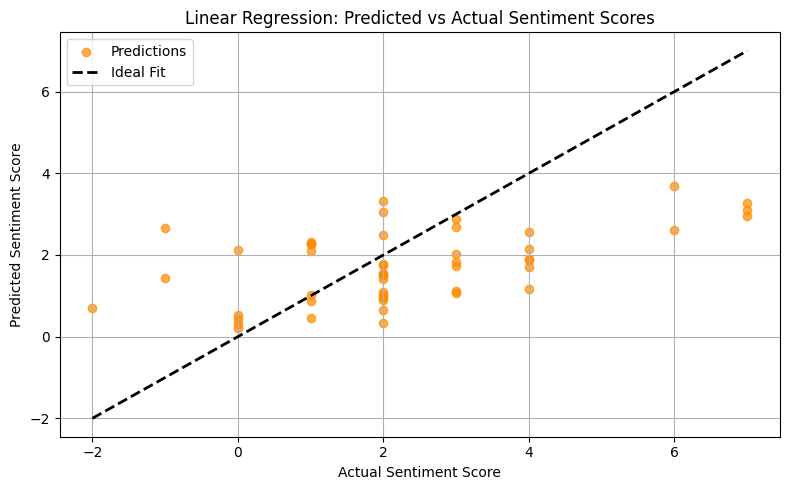

In [62]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='darkorange', alpha=0.7, label="Predictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label="Ideal Fit")
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Linear Regression: Predicted vs Actual Sentiment Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("visualization/task6_sentiment_regression_plot.png")
plt.show()


### Summary of Task 6 - Predictive Modeling

In this task, I trained a linear regression model to predict monthly sentiment scores using features derived from employee messages. The selected inputs included:

- Message Count per employee per month

- Average Message Length

- Total Message Length

These features were chosen based on their logical connection to sentiment behavior, following FAQ Q6 guidance on thoughtful, domain-aware feature selection.

After splitting the data into training and test sets, the model was evaluated using:

- R² Score: Indicates the proportion of variance explained (~21%)

- Mean Squared Error (MSE): Captures average prediction error (~3.18)

A plot comparing predicted vs actual sentiment scores highlights how closely (or not) the model aligns with reality. The dashed line represents perfect predictions — most points are near this line but show noticeable variance, indicating limited but non-trivial predictive power.

This approach meets the modeling requirements by:

- Using meaningful features

- Applying proper evaluation metrics (FAQ Q7)

- Interpreting outputs without over-relying on the model (FAQ Q8/Q9)

Overall, this task demonstrates that while basic message metrics offer some predictive signal, more advanced techniques or additional features would be needed for stronger accuracy.

